# Importing neccesary libs, data and preprocessing

## Import libs and data

In [1]:
import numpy as np
import pandas as pd
import seaborn as  sns
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV

df = pd.read_csv('dataset/creditcard.csv')
colors = sns.color_palette("RdPu", 10)


In [2]:
X = df.drop('Class', axis=1)
y = df['Class']

## Scaling amount and time features

In [3]:
from sklearn.preprocessing import StandardScaler, RobustScaler

# RobustScaler is less prone to outliers.

std_scaler = StandardScaler()
rob_scaler = RobustScaler()

df['scaled_amount'] = rob_scaler.fit_transform(df['Amount'].values.reshape(-1,1))
df['scaled_time'] = rob_scaler.fit_transform(df['Time'].values.reshape(-1,1))

df.drop(['Time','Amount'], axis=1, inplace=True)

scaled_amount = df['scaled_amount']
scaled_time = df['scaled_time']

df.drop(['scaled_amount', 'scaled_time'], axis=1, inplace=True)
df.insert(0, 'scaled_amount', scaled_amount)
df.insert(1, 'scaled_time', scaled_time)
#df.head().T

## Random Under-Sampling

In [4]:
#shuffle the data before creating the subsamples
df = df.sample(frac=1)

# amount of fraud classes 492 rows.
fraud_df = df.loc[df['Class'] == 1]
non_fraud_df = df.loc[df['Class'] == 0][:492]

normal_distributed_df = pd.concat([fraud_df, non_fraud_df])

# Shuffle dataframe rows
undersampled_df = normal_distributed_df.sample(frac=1, random_state=42)
# undersampled_df.head().T

## Removing outliers

In [5]:
# # -----> V14 Removing Outliers (Highest Negative Correlated with Labels)
v14_fraud = undersampled_df['V14'].loc[undersampled_df['Class'] == 1].values
q25, q75 = np.percentile(v14_fraud, 25), np.percentile(v14_fraud, 75)
v14_iqr = q75 - q25

v14_cut_off = v14_iqr * 1.5
v14_lower, v14_upper = q25 - v14_cut_off, q75 + v14_cut_off
outliers = [x for x in v14_fraud if x < v14_lower or x > v14_upper]
undersampled_df = undersampled_df.drop(undersampled_df[(undersampled_df['V14'] > v14_upper) | (undersampled_df['V14'] < v14_lower)].index)

# -----> V12 removing outliers from fraud transactions
v12_fraud = undersampled_df['V12'].loc[undersampled_df['Class'] == 1].values
q25, q75 = np.percentile(v12_fraud, 25), np.percentile(v12_fraud, 75)
v12_iqr = q75 - q25

v12_cut_off = v12_iqr * 1.5
v12_lower, v12_upper = q25 - v12_cut_off, q75 + v12_cut_off
undersampled_df = undersampled_df.drop(undersampled_df[(undersampled_df['V12'] > v12_upper) | (undersampled_df['V12'] < v12_lower)].index)

# -----> V10 removing outliers from fraud transactions
v10_fraud = undersampled_df['V10'].loc[undersampled_df['Class'] == 1].values
q25, q75 = np.percentile(v10_fraud, 25), np.percentile(v10_fraud, 75)
v10_iqr = q75 - q25

v10_cut_off = v10_iqr * 1.5
v10_lower, v10_upper = q25 - v10_cut_off, q75 + v10_cut_off
outliers = [x for x in v10_fraud if x < v10_lower or x > v10_upper]
undersampled_df = undersampled_df.drop(undersampled_df[(undersampled_df['V10'] > v10_upper) | (undersampled_df['V10'] < v10_lower)].index)

## Dimensionality Reduction and Clustering for undersampled data

In [6]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
# T-SNE Implementation
X_undersampled = undersampled_df.drop('Class', axis=1)
y_undersampled = undersampled_df['Class']
X_reduced_tsne = TSNE(n_components=2, random_state=42).fit_transform(X_undersampled.values)

# PCA Implementation
X_reduced_pca = PCA(n_components=2, random_state=42).fit_transform(X_undersampled.values)

# TruncatedSVD
X_reduced_svd = TruncatedSVD(n_components=2, algorithm='randomized', random_state=42).fit_transform(X_undersampled.values)

C:\Users\atik_\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\atik_\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


## Oversampling imbalanced data using RandomOverSampler

In [7]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=49)
X_oversampled_ros, y_oversampled_ros = ros.fit_resample(X,y) 

## Oversampling using SMOTE Technique

In [8]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy='minority')
X_oversampled_smote, y_oversampled_smote = smote.fit_resample(X, y)

## Model evaluation function

In [9]:
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, precision_score, f1_score
def calculate_metrics(y_actual, y_pred):
    f1_sc = f1_score(y_actual, y_pred)
    acc_sc = accuracy_score(y_actual, y_pred)
    rec_sc = recall_score(y_actual, y_pred)
    prec_sc = precision_score(y_actual, y_pred)
    conf = confusion_matrix(y_actual, y_pred)
    res = " accuracy score: {}\n recall_score: {}\n precision_score: {}\n f1_score: {}"
    print(res.format(acc_sc, rec_sc, prec_sc, prec_sc, f1_sc))
    
    return conf

## Confusion matrix visualization function

In [10]:
def visualize_conf_mat(cf_matrix, ax=None):
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                        cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
            zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    categories = ['Non-fraud', 'Fraud']
    if ax:
        sns.heatmap(cf_matrix, annot=labels, ax=ax, fmt='', xticklabels=categories, yticklabels=categories, cmap='Blues')
    else:
        sns.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=categories, yticklabels=categories, cmap='Blues')


## Split data into training and test sets

In [15]:
from sklearn.model_selection import train_test_split

# # Original data
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) 

# # Undersampled data
# X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42) 
## TO DO not use splitting for oversampled data
# # Oversampled data - ROS
#X_train, X_test, y_train, y_test = train_test_split(X_oversampled_ros, y_oversampled_ros, test_size=0.2, random_state=42) 

# Oversampled data - SMOTE
X_train, X_test, y_train, y_test = train_test_split(X_oversampled_smote, y_oversampled_smote, test_size=0.2, random_state=42) 

# Model building

## Logistic Regression

### With Undersampled data

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 3/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 4/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 5/5] END ...................C=0.1, penalty=l1;, score=nan total time=   0.0s
[CV 1/5] END .................C=0.1, penalty=l2;, score=0.904 total time=   0.0s
[CV 2/5] END .................C=0.1, penalty=l2;, score=0.878 total time=   0.0s
[CV 3/5] END .................C=0.1, penalty=l2;, score=0.878 total time=   0.0s
[CV 4/5] END .................C=0.1, penalty=l2;, score=0.927 total time=   0.0s
[CV 5/5] END .................C=0.1, penalty=l2;, score=0.939 total time=   0.0s
[CV 1/5] END .................C=0.001, penalty=l1;, score=nan total time=   0.0s
[CV 2/5] END .................C=0.001, penalty=l1

C:\Users\atik_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
10 fits failed out of a total of 20.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 447, in _check_solver
    raise ValueError(
Valu

----------------------------
The training accuracy
----------------------------
 accuracy score: 0.9481132075471698
 recall_score: 0.9148418491484185
 precision_score: 0.9766233766233766
 f1_score: 0.9766233766233766
----------------------------
The test accuracy
----------------------------
 accuracy score: 0.9263157894736842
 recall_score: 0.8478260869565217
 precision_score: 1.0
 f1_score: 1.0


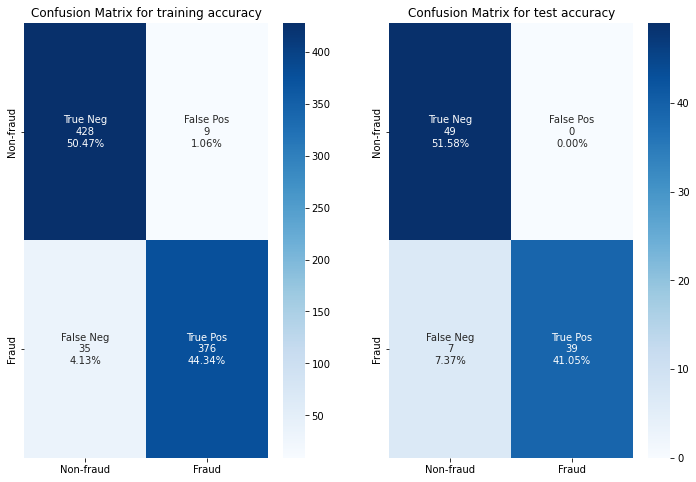

In [29]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV

model = LogisticRegression()
log_reg_params = {"penalty": ['l1', 'l2'], 'C': [0.001, 0.01, 0.1]}
rand_log_reg = RandomizedSearchCV(LogisticRegression(), param_distributions=log_reg_params, n_iter=4, scoring='recall', verbose=3)
rand_log_reg.fit(X_train, y_train)
best_est = rand_log_reg.best_estimator_

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)

## Support Vector Machine

### With Undersampled data

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END ......C=1, degree=1, kernel=linear;, score=0.861 total time=   0.0s
[CV 2/5] END ......C=1, degree=1, kernel=linear;, score=0.917 total time=   0.0s
[CV 3/5] END ......C=1, degree=1, kernel=linear;, score=0.889 total time=   0.0s
[CV 4/5] END ......C=1, degree=1, kernel=linear;, score=0.859 total time=   0.0s
[CV 5/5] END ......C=1, degree=1, kernel=linear;, score=0.803 total time=   0.0s
[CV 1/5] END .........C=1, degree=2, kernel=rbf;, score=0.819 total time=   0.0s
[CV 2/5] END .........C=1, degree=2, kernel=rbf;, score=0.889 total time=   0.0s
[CV 3/5] END .........C=1, degree=2, kernel=rbf;, score=0.875 total time=   0.0s
[CV 4/5] END .........C=1, degree=2, kernel=rbf;, score=0.831 total time=   0.0s
[CV 5/5] END .........C=1, degree=2, kernel=rbf;, score=0.789 total time=   0.0s
[CV 1/5] END ........C=1, degree=3, kernel=poly;, score=0.875 total time=   0.0s
[CV 2/5] END ........C=1, degree=3, kernel=poly;

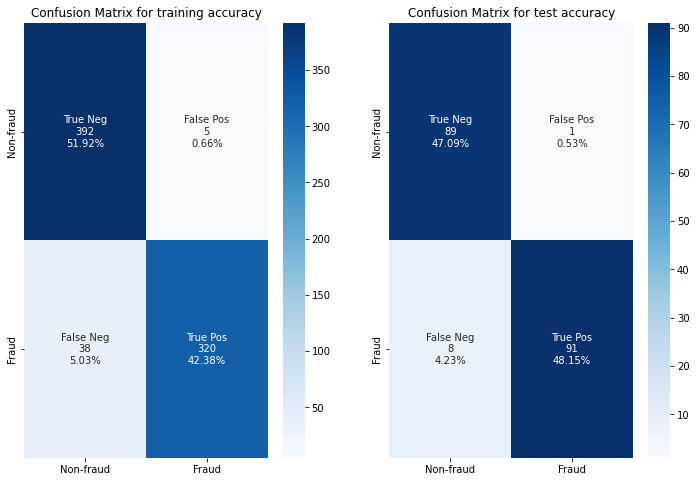

In [12]:
# # Undersampled data
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42) 

from sklearn.svm import SVC
svm_c = SVC()
parameters = {
    'C': list(range(1,3)),
    'kernel': ['linear', 'poly', 'rbf'],
    'degree': list(range(1,4))
}

# Run a randomized search over the hyperparameters
rnd_svm = RandomizedSearchCV(svm_c, param_distributions=parameters, scoring='recall', verbose=3)

# wasn't able to get a result without scaling
from sklearn.preprocessing import MinMaxScaler
scaled = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaled.transform(X_train)
X_test = scaled.transform(X_test)

rnd_svm.fit(X_train, y_train)

best_est = rnd_svm.best_estimator_
y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)

## Decision Tree

### With Oversampled data - SMOTE

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_leaf=10;, score=0.997 total time=  24.9s
[CV 2/5] END criterion=entropy, max_depth=20, min_samples_leaf=10;, score=0.998 total time=  24.8s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_leaf=10;, score=0.998 total time=  27.6s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_leaf=10;, score=0.998 total time=  27.2s
[CV 5/5] END criterion=entropy, max_depth=20, min_samples_leaf=10;, score=0.998 total time=  25.9s
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=30;, score=0.992 total time=  26.2s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=30;, score=0.993 total time=  23.6s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=30;, score=0.992 total time=  23.7s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=30;, score=0.992 total time=  23.2s
[CV 5/5] END criterion=entropy, max_depth=10, mi

C:\Users\atik_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 937, in fit
    super().fit(
  File "C:\Users\atik_\anaconda3\lib\site-packages\sklearn\tree\_classes.py", line 352, in fit
    criterion = CRITERIA_CLF[self.criterion](
KeyError: 'log_loss'

  warnings.warn(some_fits_failed_me

{'min_samples_leaf': 10, 'max_depth': 20, 'criterion': 'entropy'}
----------------------------
The training accuracy
----------------------------
 accuracy score: 0.9989338409862301
 recall_score: 0.999133452685197
 precision_score: 0.9987336762960032
 f1_score: 0.9987336762960032
----------------------------
The test accuracy
----------------------------
 accuracy score: 0.9978896646325378
 recall_score: 0.9984379387812412
 precision_score: 0.9973526420982503
 f1_score: 0.9973526420982503


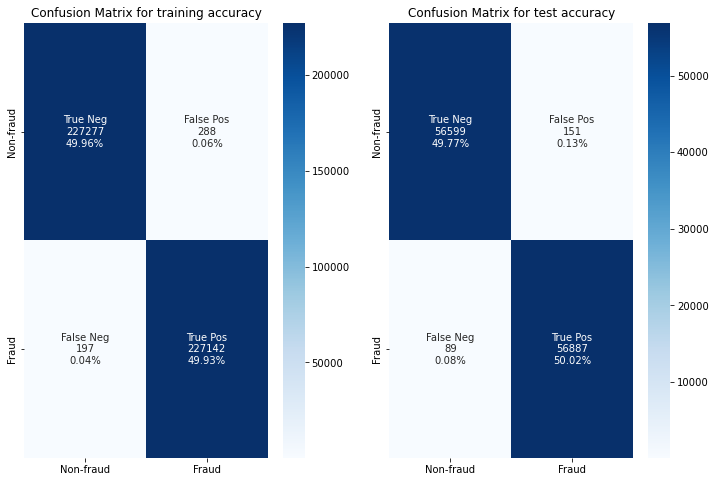

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_oversampled_smote, y_oversampled_smote, test_size=0.2, random_state=42) 

from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {"criterion" : ['gini', 'entropy'], 'max_depth' : [5,10,20,30], 'min_samples_leaf': [6,10,20,30,40,200]}
rnd_dtree = RandomizedSearchCV(dtree, param_distributions=param_grid, scoring='recall', verbose=3)

rnd_dtree.fit(X_train, y_train)
print(rnd_dtree.best_params_)

best_est = rnd_dtree.best_estimator_

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)

### With Undersampled data

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END criterion=entropy, max_depth=10, min_samples_leaf=20;, score=0.892 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=10, min_samples_leaf=20;, score=0.915 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=10, min_samples_leaf=20;, score=0.866 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=10, min_samples_leaf=20;, score=0.951 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=10, min_samples_leaf=20;, score=0.927 total time=   0.0s
[CV 1/5] END criterion=entropy, max_depth=20, min_samples_leaf=20;, score=0.892 total time=   0.0s
[CV 2/5] END criterion=entropy, max_depth=20, min_samples_leaf=20;, score=0.915 total time=   0.0s
[CV 3/5] END criterion=entropy, max_depth=20, min_samples_leaf=20;, score=0.866 total time=   0.0s
[CV 4/5] END criterion=entropy, max_depth=20, min_samples_leaf=20;, score=0.951 total time=   0.0s
[CV 5/5] END criterion=entropy, max_depth=20, mi

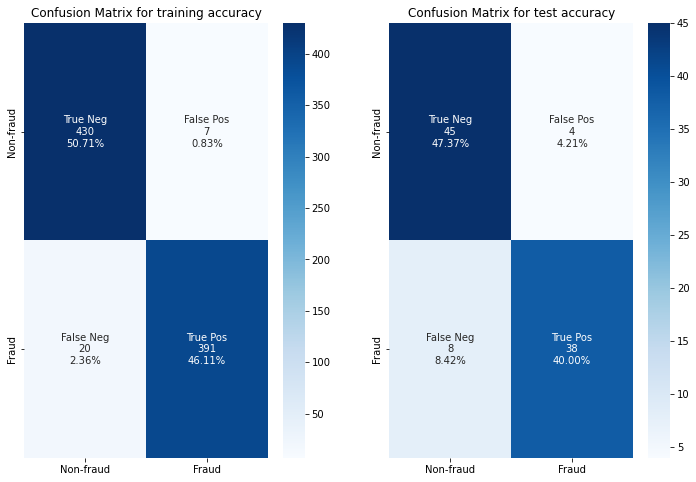

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.1, random_state=42) 

from sklearn.tree import DecisionTreeClassifier
dtree = DecisionTreeClassifier()

param_grid = {"criterion" : ['gini', 'entropy'], 'max_depth' : [5,10,20,25], 'min_samples_leaf': [6,10,20,30,40,200]}
rnd_dtree = RandomizedSearchCV(dtree, param_distributions=param_grid, scoring='recall', verbose=3)

rnd_dtree.fit(X_train, y_train)
print(rnd_dtree.best_params_)

best_est = rnd_dtree.best_estimator_

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)

## AdaBoost

### With Undersampled data

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END learning_rate=1.0, n_estimators=75;, score=0.863 total time=   0.2s
[CV 2/5] END learning_rate=1.0, n_estimators=75;, score=0.932 total time=   0.1s
[CV 3/5] END learning_rate=1.0, n_estimators=75;, score=0.918 total time=   0.1s
[CV 4/5] END learning_rate=1.0, n_estimators=75;, score=0.919 total time=   0.1s
[CV 5/5] END learning_rate=1.0, n_estimators=75;, score=0.959 total time=   0.1s
[CV 1/5] END learning_rate=0.5, n_estimators=105;, score=0.863 total time=   0.2s
[CV 2/5] END learning_rate=0.5, n_estimators=105;, score=0.945 total time=   0.2s
[CV 3/5] END learning_rate=0.5, n_estimators=105;, score=0.904 total time=   0.2s
[CV 4/5] END learning_rate=0.5, n_estimators=105;, score=0.905 total time=   0.2s
[CV 5/5] END learning_rate=0.5, n_estimators=105;, score=0.945 total time=   0.2s
[CV 1/5] END learning_rate=1.0, n_estimators=285;, score=0.863 total time=   0.7s
[CV 2/5] END learning_rate=1.0, n_estimato

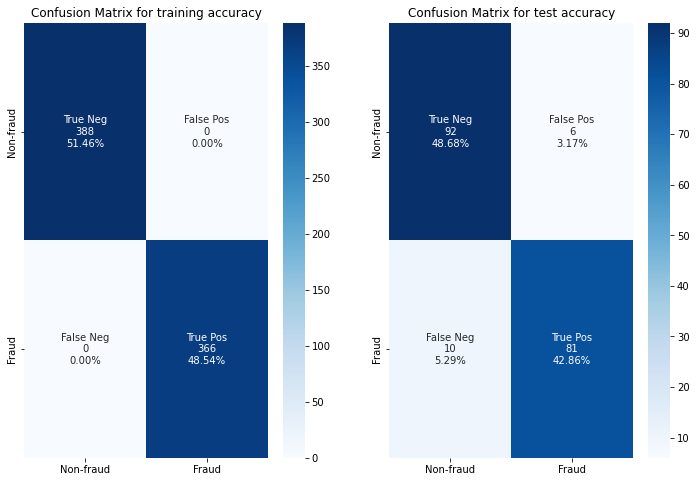

In [31]:
X_train, X_test, y_train, y_test = train_test_split(X_undersampled, y_undersampled, test_size=0.2, random_state=42) 

from sklearn.ensemble import AdaBoostClassifier
adab_c = AdaBoostClassifier()

param_grid = {
    'n_estimators': list(range(30,300,15)),
    'learning_rate': [0.01,0.1,0.5,1.0]
}
rnd_ada = RandomizedSearchCV(adab_c, param_distributions=param_grid, scoring='recall', verbose=3)

rnd_ada.fit(X_train, y_train)
print(rnd_ada.best_params_)

best_est = rnd_ada.best_estimator_

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)

## Gradient Boosting

### With Undersampled data

Fitting 5 folds for each of 10 candidates, totalling 50 fits
{'subsample': 0.85, 'n_estimators': 10, 'min_samples_split': 0.390909090909091, 'min_samples_leaf': 0.13636363636363638, 'max_features': 'log2', 'max_depth': 5, 'loss': 'deviance', 'learning_rate': 0.05, 'criterion': 'friedman_mse'}
----------------------------
The training accuracy
----------------------------
 accuracy score: 0.9323607427055703
 recall_score: 0.8743169398907104
 precision_score: 0.9846153846153847
 f1_score: 0.9846153846153847
----------------------------
The test accuracy
----------------------------
 accuracy score: 0.9153439153439153
 recall_score: 0.8681318681318682
 precision_score: 0.9518072289156626
 f1_score: 0.9518072289156626


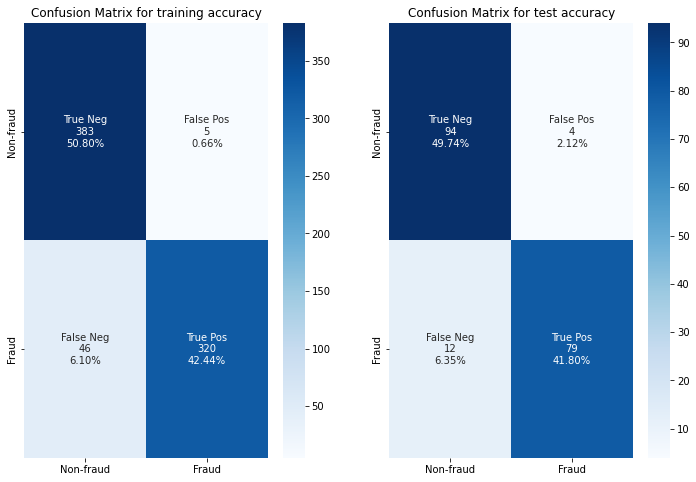

In [37]:
from sklearn.ensemble import GradientBoostingClassifier
grad_boost = GradientBoostingClassifier()

param_grid = {
    "loss":["deviance"],
    "learning_rate": [0.01, 0.025, 0.05, 0.075, 0.1, 0.15, 0.2],
    "min_samples_split": np.linspace(0.1, 0.5, 12),
    "min_samples_leaf": np.linspace(0.1, 0.5, 12),
    "max_depth":[3,5,8],
    "max_features":["log2","sqrt"],
    "criterion": ["friedman_mse",  "squared_error"],
    "subsample":[0.5, 0.618, 0.8, 0.85, 0.9, 0.95, 1.0],
    "n_estimators":[10]
    }

rnd_grad = RandomizedSearchCV(grad_boost, param_distributions=param_grid, scoring='f1', verbose=3, n_jobs=-1)

rnd_grad.fit(X_train, y_train)
print(rnd_grad.best_params_)

best_est = rnd_grad.best_estimator_

y_train_pred = best_est.predict(X_train)
y_test_pred = best_est.predict(X_test)

print('----------------------------\nThe training accuracy\n----------------------------')
train_conf_mat = calculate_metrics(y_train, y_train_pred)
print('----------------------------\nThe test accuracy\n----------------------------')
test_conf_mat = calculate_metrics(y_test, y_test_pred)

f, (ax1, ax2) = plt.subplots(1, 2,figsize=(12, 8))

ax1.set_title('Confusion Matrix for training accuracy')
visualize_conf_mat(train_conf_mat, ax1)

ax2.set_title('Confusion Matrix for test accuracy')
visualize_conf_mat(test_conf_mat, ax2)